In [1]:
!pip install ax-platform

     |████████████████████████████████| 501kB 15.6MB/s 
     |████████████████████████████████| 225kB 58.8MB/s 
     |████████████████████████████████| 286kB 57.9MB/s 
  Created wheel for gpytorch: filename=gpytorch-1.3.0-py2.py3-none-any.whl size=473796 sha256=6746f06c9885934623364da140e4b17c73f171f228b7c74a64ba96b12ce80270
  Stored in directory: /root/.cache/pip/wheels/4c/b2/5d/79ddf695f614490bde2d65f28b7a170ddd1cea74ac3c2bf807
Successfully built gpytorch


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified



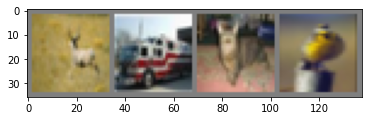

[INFO 01-07 08:51:54] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 5 arms, GPEI for subsequent arms], generated 0 arm(s) so far). Iterations after 5 will take longer to generate due to model-fitting.
[INFO 01-07 08:51:54] ax.service.managed_loop: Started full optimization with 20 steps.
[INFO 01-07 08:51:54] ax.service.managed_loop: Running optimization trial 1...


 deer truck   cat  bird
running optimization


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


100%|██████████| 3/3 [00:51<00:00, 17.31s/it]
[INFO 01-07 08:53:21] ax.service.managed_loop: Running optimization trial 2...
100%|██████████| 3/3 [00:44<00:00, 14.83s/it]
[INFO 01-07 08:54:30] ax.service.managed_loop: Running optimization trial 3...
100%|██████████| 3/3 [01:36<00:00, 32.00s/it]
[INFO 01-07 08:56:30] ax.service.managed_loop: Running optimization trial 4...
100%|██████████| 3/3 [00:46<00:00, 15.38s/it]
[INFO 01-07 08:57:40] ax.service.managed_loop: Running optimization trial 5...
100%|██████████| 3/3 [01:05<00:00, 21.86s/it]
[INFO 01-07 08:59:10] ax.service.managed_loop: Running optimization trial 6...
100%|██████████| 3/3 [02:07<00:00, 42.50s/it]
[INFO 01-07 09:01:43] ax.service.managed_loop: Running optimization trial 7...
100%|██████████| 3/3 [02:07<00:00, 42.54s/it]
[INFO 01-07 09:04:16] ax.service.managed_loop: Running optimization trial 8...
100%|██████████| 3/3 [02:09<00:00, 43.08s/it]
[INFO 01-07 09:06:50] ax.service.managed_loop: Running optimization trial 9...


best parameters {'lr': 0.016882011752037126, 'batchsize': 91, 'momentum': 0.3016660991448547, 'max_epoch': 6}
{'accuracy': 0.5072999779862108}
{'accuracy': {'accuracy': 2.4257406654831127e-09}}


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm
from ax.plot.contour import plot_contour
from ax.plot.trace import optimization_trace_single_method
from ax.service.managed_loop import optimize
from ax.utils.notebook.plotting import render
from ax.utils.tutorials.cnn_utils import train, evaluate

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((.5, .5, .5), (.5, .5, .5))])

trainset = torchvision.datasets.CIFAR10(root = './data', train = True, download = True, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 4, shuffle = True, num_workers = 2)

testset = torchvision.datasets.CIFAR10(root = './data', train = False, download = True, transform = transform)

# A dataloader takes a dataset as an argument.
testloader = torch.utils.data.DataLoader(testset, batch_size = 4, shuffle = False, num_workers = 2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img/2 + .5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get random training images.
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s'%classes[labels[j]] for j in range(4)))

# Ax requires a function that returns a trained model and another that evaluates and returns a performance metric.
def net_train(net, train_loader, parameters, dtype, device):
    """
    Trains the network and returns the trained model.
    """
    net.to(dtype = dtype, device = device)

    # Define loss and Optimizer.
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr = parameters.get('lr', 0.001), momentum = parameters.get('momentum', .9))

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = int(parameters.get('step_size', 30)), gamma = parameters.get('gamma', 1.))
    num_epochs = parameters.get('num_epochs', 3)
    for _ in tqdm(range(num_epochs)):
        for inputs, labels in train_loader:
            inputs = inputs.to(dtype = dtype, device = device)
            labels = labels.to(dtype = dtype, device = device)

            #y_tensor = torch.tensor(y_train, dtype=torch.long, device=device)
            # Zero the gradients of the prameters.
            optimizer.zero_grad()

            # Forward pass & Backward pass & Optimize.
            outputs = net(inputs)
            loss = criterion(outputs, labels.long())
            loss.backward()
            optimizer.step()
            scheduler.step()
    return net

def init_net(parametrization):
    """
    Initializes the model using a certain set of parameters a,nd returns a ready-to-train model.
    """
    model = torchvision.models.resnet50(pretrained = True)

    for param in model.parameters():
        # freeze the feature extractor.
        param.requires_grad = False
    # Hidden layer size, will not be optimized here.
    Hs = 512

    model.fc = torch.nn.Sequential(torch.nn.Linear(2048, Hs), torch.nn.ReLU(), torch.nn.Dropout(.2), torch.nn.Linear(Hs, 10), torch.nn.LogSoftmax(dim = 1))
    return model

def train_evaluate(parametrization):
    """
    Trains the model with the submitted parametrization and returns the score obtained on the evaluation metric.
    """
    # Constructing new training dataloaders aloow us to tune the batch_size.
    train_loader = torch.utils.data.DataLoader(trainset, batch_size = int(parametrization.get('batchsize', 32)), shuffle = True, num_workers = 0, pin_memory = True)

    # Get neural network
    untrained_net = init_net(parametrization)

    # train
    trained_net = net_train(net = untrained_net, train_loader = train_loader, parameters = parametrization, dtype = dtype, device = device)

    # Return the evaluation metric obtained from the trained model.
    return evaluate(net = trained_net, data_loader = testloader, dtype = dtype, device = device)


# Specify the parameters that you want to optimize.
dtype = torch.float
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('running optimization')
best_parameters, values, experiment, model = optimize(
    parameters = [
        {'name' : 'lr', 'type' : 'range', 'bounds' : [1e-6, .4], 'log_scale' : True},
        {'name' : 'batchsize', 'type' : 'range', 'bounds' : [16, 128]},
        {'name' : 'momentum', 'type' : 'range', 'bounds' : [0.0, 1.0]},
        {'name' : 'max_epoch', 'type' : 'range', 'bounds' : [1, 30]}
    ],
    evaluation_function = train_evaluate,
    objective_name = 'accuracy',
)

print('best parameters', best_parameters)
means, covariances = values
print(means)
print(covariances)